# Analysis of UK House Market Data
We are going to analyse the market data from the UK housing market, with a dataset in a .CSV format downloaded from [kaggle](https://www.kaggle.com/datasets/lorentzyeung/price-paid-data-202304).
The data has been sourced from the UK government's HM Land Registry for the time period of 1995 - 2023-05-01.


# 1.0 Importing the tools we are going to use
* Pandas
* Numpy
* Matplotlib
* Plotly
* Seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib as mpl
import seaborn as sns

# 1.1 Creating an instance of the read CSV file

In [2]:
uk_house_data_all = pd.read_csv(
    'datasets/uk_house_market_data.csv',
    names=[
        'Transaction_unique_identifier',
        'price',
        'date_of_sale',
        'postcode',
        'property_type',
        'old_new',
        'duration',
        'PAON',
        'SAON',
        'street',
        'locality',
        'town_city',
        'district',
        'county',
        'ppd_category_type',
        'record_status',
    ],
    dtype={'price': 'int64'}
)


# 1.2 Creating a smaller set of data
We won't need all the data from the dataset, so we make a smaller one to increase processing speed

In [41]:
sales_data_20_years = uk_house_data_all.query('date_of_sale >= "2000-01-01 00:00"')

# 2.0 Extracting data from year 2015 to 2023
Extracting the data from 2015 to 2023, so we can:
* Compare sales through the years
* Determine sales trends
    * Best property selling months
    * Worst property selling months
    * Average properties sold

**Methodology**
Create a dictionary to store the data for each year, we store a string with sales_data_{year} as **keys** and the results of the dataset for the time period of that year as **values**

In [4]:
yearly_data_since_2015 = {}

for year in range(2015, 2024):
    name = f"sales_data_{year}"
    values = sales_data_20_years[sales_data_20_years['date_of_sale'].str.startswith(f'{str(year)}')]
    yearly_data_since_2015[name] = values


# 2.1 Count properties sold for each year
Here we are going to create two new dictionaries:
1. To store the count of all properties sold throughout those years
2. To store the count of properties sold until May of each year

**We need to have a second dictionary with the count of properties sold until May, because the dataset ends in May 2023, and it will be inappropriate to compare yearly data for a year that hasn't got all the data collected yet.**

In [5]:
yearly_properties_sold = {
    int(key[-4:]) : value['date_of_sale'].count()
    for key, value in yearly_data_since_2015.items()
}

yearly_properties_sold_until_may = {}

for key, value in yearly_data_since_2015.items():
    year = key[-4:]
    till_may = value.loc[value['date_of_sale'] <= f"{year}-05-01"]
    yearly_properties_sold_until_may[year] = till_may['date_of_sale'].count()   

# 2.2 Visualize the results
Visualizing the yearly property sold until May

<BarContainer object of 9 artists>

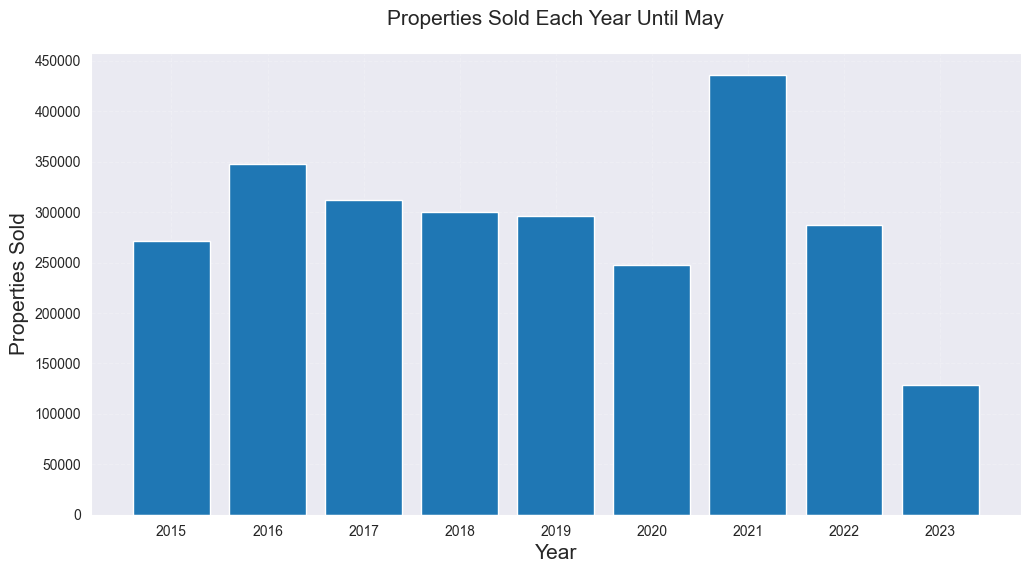

In [6]:
from matplotlib.pyplot import MultipleLocator

fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.2, ls='dashed')
ax.set_title('Properties Sold Each Year Until May', fontsize=15, pad=20)
plt.ylabel('Properties Sold', fontsize=15)
plt.xlabel('Year', fontsize=15)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(50000))
ax.yaxis.set_minor_locator(MultipleLocator(10000))

ax.bar(
    yearly_properties_sold_until_may.keys(), yearly_properties_sold_until_may.values()
)


# 2.3 Average Properties Sold
**Finding out the average properties sold for the year 2015-2023 and displaying how is 2023 compared to the average**
* Get the sum of the values in the properties_sold_until_may dictionary and divide with the length of the values()
* Find the percentage change of properties sold to the average
* Display it in a fig with two ax

Text(0, 0.5, 'In Percent')

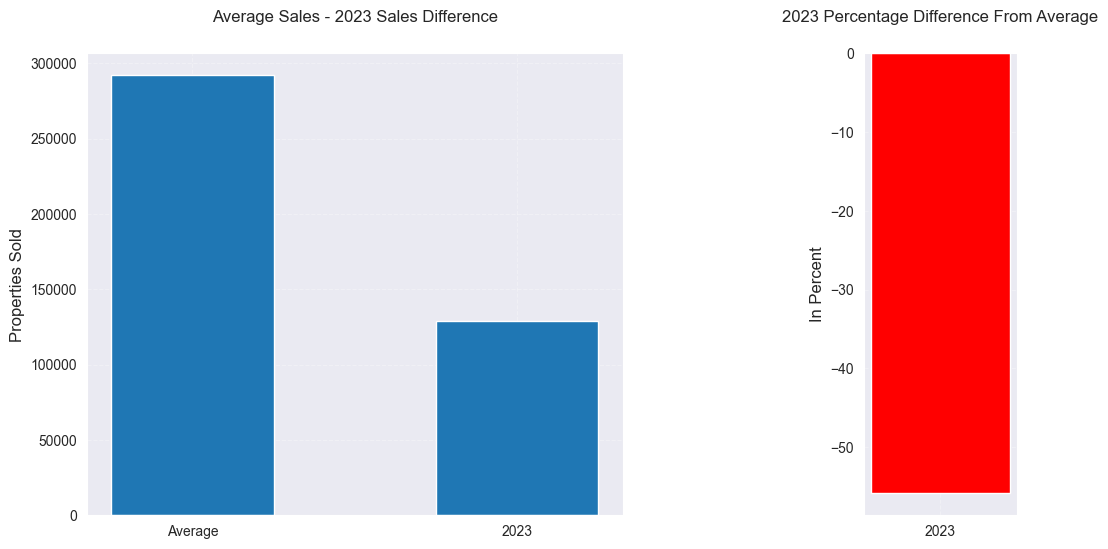

In [7]:
average_properties_sold_until_may_2015_2023 = sum(yearly_properties_sold_until_may.values()) / len(yearly_properties_sold_until_may.values())

values_to_compare = [
    average_properties_sold_until_may_2015_2023,
    yearly_properties_sold_until_may['2023']
]

percentage_difference_average_and_2023 = (
    (
            (yearly_properties_sold_until_may['2023'] - average_properties_sold_until_may_2015_2023) / average_properties_sold_until_may_2015_2023
    ) * 100
)

width_ratios = [7, 2]
fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': width_ratios})
plt.subplots_adjust(wspace=0.7)
ax[0].grid(True, alpha=0.3, ls='dashed')
ax[0].set_title('Average Sales - 2023 Sales Difference', y=1.05)
ax[0].bar(['Average', '2023'], values_to_compare, width=0.5, align='center')
ax[0].set_ylabel('Properties Sold', fontdict={'fontsize': 12})

ax[1].grid(True, alpha=0.3, ls='dashed')
ax[1].set_title('2023 Percentage Difference From Average', y=1.05)
ax[1].bar('2023', percentage_difference_average_and_2023, color='red')
ax[1].yaxis.set_minor_locator(MultipleLocator(1))
ax[1].set_ylabel('In Percent', fontdict={'fontsize': 12})


# 2.3.1 Conclusion
The first 4 months of properties sold in 2023 have decreased by slightly over 55% which was primarily driven by high interest rates in combination with high inflation and high property prices.

*Note:*
*Get interest rate data to make comparison better*

# 2.4 Compare all years to a three years moving average
Compare every year property sales data until May, from 2017 to 2023
**We compare prices from 2017, because in order to get 3 years moving average we need to collect data from 2 years prior the current year**

Steps:
* Create pd.Series with the data from the dictionary about each year sales until May  *Having 'sold' column*
* Convert it into a pd.DataFrame and reset the index *The previous index column will be renamed to 'year'*
* Create new column 'moving_average' which will be the rolling(window=3).mean of the 'sold' column
* Create a new column 'percentage_change' to store the percentage representation of the the difference between the years sold properties and the 3 years moving average
* Drop any N/A rows

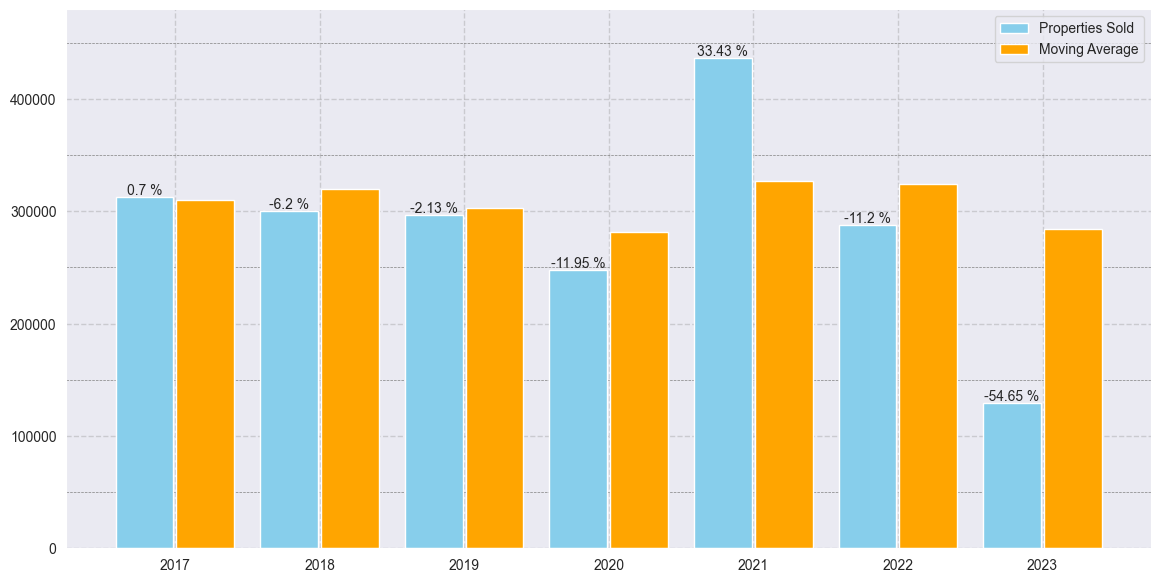

In [8]:
three_year_moving_average_sales = pd.Series(yearly_properties_sold_until_may, name='sold').to_frame().reset_index(names=['year'])
three_year_moving_average_sales['moving_average'] = three_year_moving_average_sales['sold'].rolling(window=3).mean().round()
three_year_moving_average_sales = three_year_moving_average_sales.dropna()
three_year_moving_average_sales['percentage_change'] = round(((three_year_moving_average_sales['sold'] - three_year_moving_average_sales['moving_average']) / three_year_moving_average_sales['moving_average'] * 100), 2)
three_year_moving_average_sales['year'] = pd.to_numeric(three_year_moving_average_sales['year'])

fig, ax = plt.subplots(figsize=(14, 7))
ax.grid(True, alpha=0.3, ls='dashed', color='gray', lw=1)
ax.grid(True, which='minor', ls='dashed', lw=0.5, color='gray')

bar_width = 0.4
bar_positions = three_year_moving_average_sales['year']

sold= ax.bar(bar_positions - bar_width / 1.9, three_year_moving_average_sales['sold'], bar_width, label='Properties Sold', color='skyblue')
moving_average = ax.bar(bar_positions + bar_width / 1.9, three_year_moving_average_sales['moving_average'], bar_width, label='Moving Average', color='orange')
ax.legend()
ax.yaxis.set_major_locator(MultipleLocator(100000))
ax.yaxis.set_minor_locator(MultipleLocator(50000))
ax.bar_label(sold, [f"{pct} %" for pct in three_year_moving_average_sales['percentage_change']])
ax.margins(y=0.1)
plt.show()



# 2.5 Check correlation between sales and interest rates
*Steps*:
* Find and import historic interest-rate data
* Process the data to our needs
* Find out correlation between interest-rates and property sales
* Visualise the results

<Axes: title={'center': 'Correlation Matrix'}>

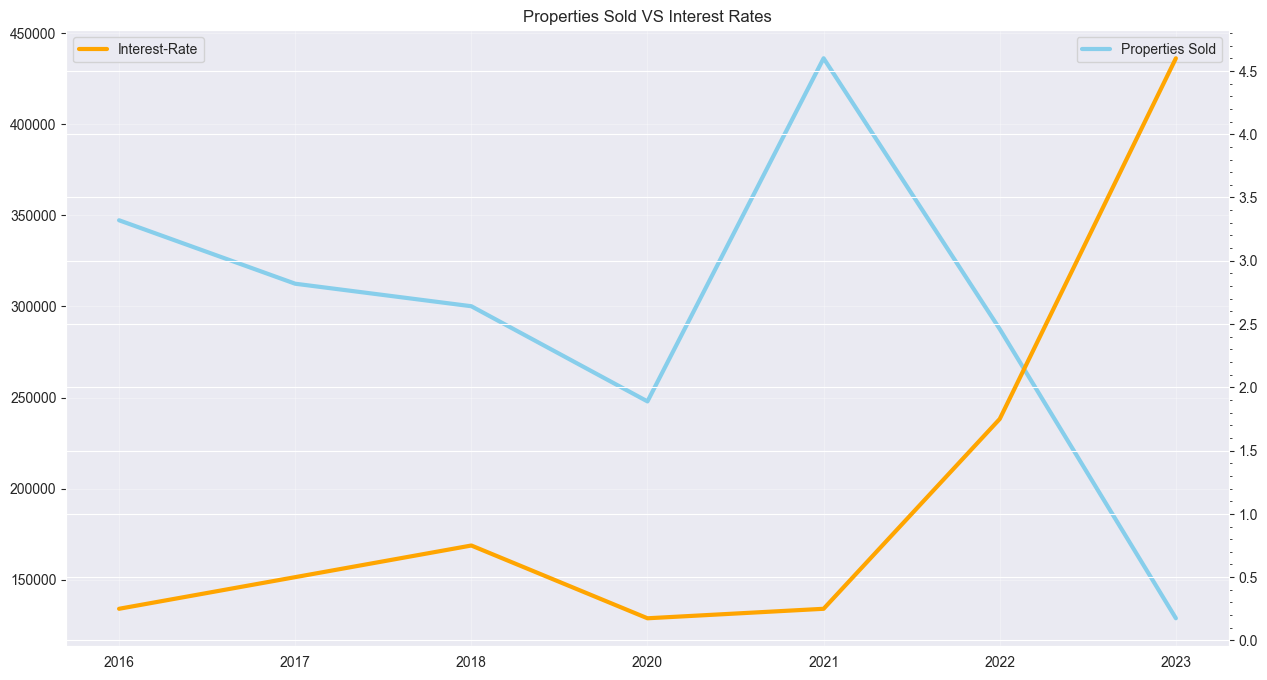

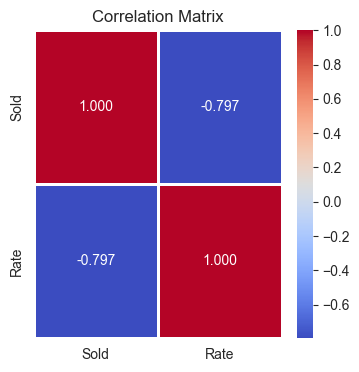

In [9]:
# Read the data and format it to what we need
interest_rates_data = pd.read_csv('datasets/Bank Rate history and data Bank of England Database.csv')

interest_rates_data['Date Changed'] = pd.to_datetime(interest_rates_data['Date Changed'], format='%d %b %y')

yearly_average_interest_rates = interest_rates_data['Rate'].groupby(interest_rates_data['Date Changed'].dt.strftime('%Y')).mean().to_frame()


yearly_average_interest_rates_2015_2023 = yearly_average_interest_rates.loc[yearly_average_interest_rates.index >= '2015']

properties_sold_till_may_frame = pd.Series(yearly_properties_sold_until_may).to_frame(name='Sold').drop(index=['2015'])

concatenated_frame = pd.concat(
    [
        properties_sold_till_may_frame,
        yearly_average_interest_rates_2015_2023
     ],
    axis=1
).dropna()

# Plot it on a shared x-axis
fig, ax = plt.subplots(figsize=(15, 8), sharey=True)
ax.grid(True, alpha=0.3)
ax.set_title("Properties Sold VS Interest Rates")

ax2 = ax.twinx()
ax.plot(concatenated_frame['Sold'], label='Properties Sold', color='skyblue', lw=3)
ax2.plot(concatenated_frame['Rate'], label='Interest-Rate', color='orange', lw=3)

ax.legend()
ax2.legend()
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))


# Calculate correlation matrix and display it using seaborn
correlation_matrix = concatenated_frame.corr()

fig_two, ax_two = plt.subplots(figsize=(4, 4))

ax_two.set_title('Correlation Matrix')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=1)


# 3.0 Full Years Data Analysis Since 2000
Include data for full years only (2023 excluded)
Information we are going to extract and visualize:
* Total Properties Sold
* Total Properties Sold for Each Year
* Average Properties Sold for the Whole Period
* Three Years Moving Average

Concatenate the two dataframes **year_to_sales_table** and **yearly_average_interest_rates** and fill in the NaN interest rate values with the ones, from previous years (since, the rate hasn't changed)

In [10]:
# Group data for each year and count properties sold
total_yearly_sales = sales_data_20_years.groupby(
    sales_data_20_years['date_of_sale'].str[:4]
).size().reset_index(name='Count').drop(index=23)
total_yearly_sales.index = total_yearly_sales['date_of_sale']
# Creating a 3 years moving average column
total_yearly_sales['moving_average'] = total_yearly_sales['Count'].rolling(window=3).mean()
# # Converting the index to an integer data type
# total_yearly_sales.index = total_yearly_sales.index.astype(int)

total_properties_sold_until_2022 = total_yearly_sales['Count'].sum()
average_properties_sold_until_2022 = total_yearly_sales['Count'].mean()

yearly_average_interest_rates_2000_2022 = yearly_average_interest_rates.query(
    'index >= "2000" & index < "2023"'
)

year_to_sales_and_interest_rates = pd.concat(
    [total_yearly_sales,
    yearly_average_interest_rates_2000_2022],
    axis=1
)
year_to_sales_and_interest_rates['Rate'] =  year_to_sales_and_interest_rates['Rate'].ffill()

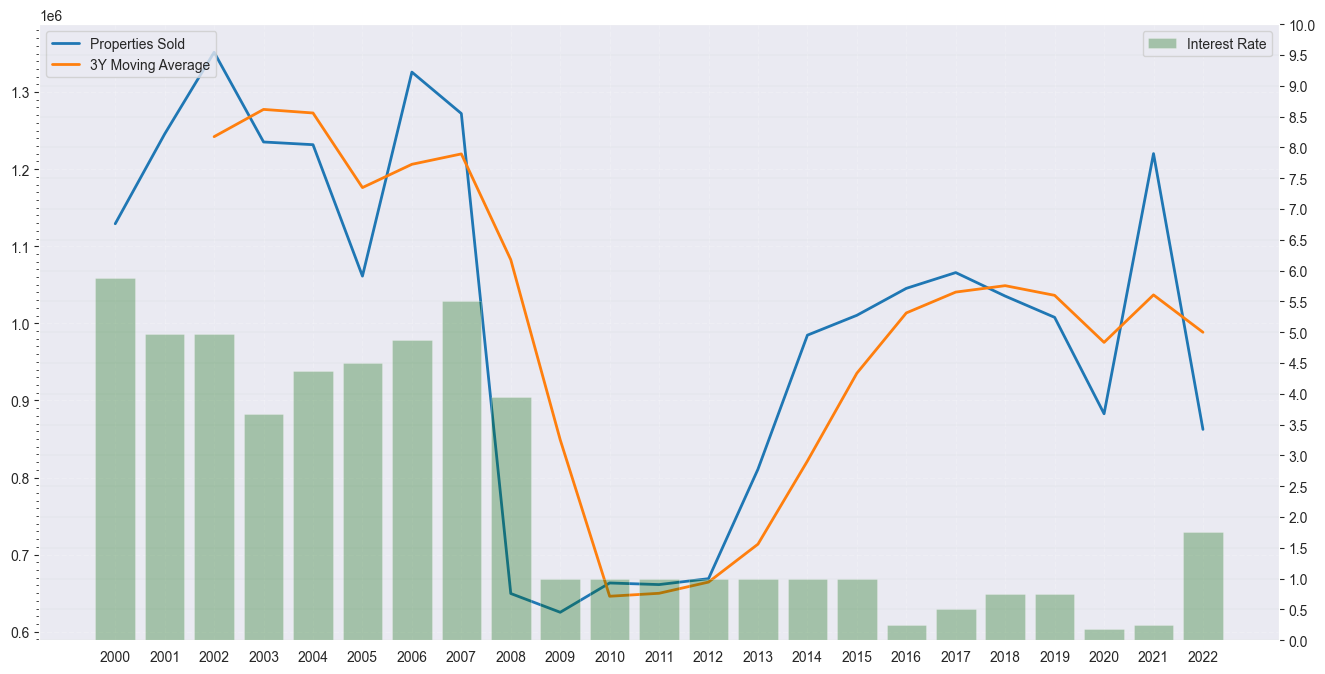

In [11]:
figure, axis = plt.subplots(figsize = (16, 8), sharey=True)
axis.grid(True, alpha=0.2, ls='dashed', lw=1)

years = year_to_sales_and_interest_rates.index

axis.plot(years, year_to_sales_and_interest_rates.Count, label='Properties Sold', lw=2)
axis.plot(years, year_to_sales_and_interest_rates.moving_average, label='3Y Moving Average', lw=2)

axis.yaxis.set_major_locator(MultipleLocator(100000))
axis.yaxis.set_minor_locator(MultipleLocator(10000))

axis_two = axis.twinx()
axis_two.grid(True, alpha=0.1, color='darkgreen', lw=0.2)
axis_two.bar(
    year_to_sales_and_interest_rates.index,
    year_to_sales_and_interest_rates.Rate,
    color='darkgreen',
    lw=0.5,
    label='Interest Rate',
    alpha=0.3,
)
axis_two.set_ylim(0, 10)

axis_two.yaxis.set_major_locator(MultipleLocator(0.5))


axis.legend(loc=2)
axis_two.legend(loc=0)


# 3.1.0 Average best-worst months for the time period

*Import calendar so you can get the month name and substitute it to the number*

Group the property sales by year and month and count all the sales that have happened in this year-month group
Find out the average monthly sales for **each year**

**Find out which of the months have performed the best by sales:**
* Group the data by year *The first [:4] characters of the .str method on the ['date_of_sale'] column*
    * Then find the .max() of the ['Count'] column (This will give us a result of only Count, and index, so we have to find out which month does it belong to)
    * Left Join the result with the *monthly_sales_for_20_years_period dataframe, on='Count'*
    * Rename the column name to month from 'date_of_sale'
    * Apply a lambda function to the ['month'] column to rename the column to a Calendar Month Name ex. January, since the format we are getting the 'date_of_sale' was 2000-01
    * Change the ['month'] column to a *pd.Catecorical()* with categories, the months of the Year, ordered.
    * Then sort the values by the ['month'] column so when visualizing the months, they will all come in their natural order

**Find out which of the months have performed the worst by sales**
* Repeat the steps above, with the only difference that we are looking for the .min() of the ['Count'] column.




**Converting the ['month'] date using the  calendar.month_name[ ] that takes an integer and displays the month name**


In [12]:
import calendar
# calendar.month_name[int(month_number)]


months_name = calendar.month_name[1:]

monthly_sales_grouped_for_20_years_period = sales_data_20_years.groupby(sales_data_20_years['date_of_sale'].str[:7]).size().reset_index(name='Count')

average_monthly_sales_per_year = (
    monthly_sales_grouped_for_20_years_period
    .groupby(
        monthly_sales_grouped_for_20_years_period['date_of_sale'].str[:4]
    )['Count']
    .mean().to_frame()
)
average_monthly_sales_per_year.index.name = 'year'


best_performing_month_per_year = (
    monthly_sales_grouped_for_20_years_period
    .groupby(
        monthly_sales_grouped_for_20_years_period['date_of_sale'].str[:4]
    )['Count'].max()
)

best_performing_month_per_year = (
    pd.merge(
        best_performing_month_per_year, monthly_sales_grouped_for_20_years_period, on='Count', how='left'
    )
)

best_performing_month_per_year = best_performing_month_per_year.rename(columns={'date_of_sale': 'month'})

best_performing_month_per_year['month'] = (
    best_performing_month_per_year['month'].apply(lambda i: calendar.month_name[int(i[5:7])])
)

best_performing_month_per_year['month'] = (
    pd.Categorical(best_performing_month_per_year['month'], categories=months_name, ordered=True)
)

best_performing_month_per_year = best_performing_month_per_year.sort_values('month')

# Cleaning the data in the 'month' column to say the month name, not half the string of the datetime

worst_performing_month_per_year = (
    monthly_sales_grouped_for_20_years_period
    .groupby(
        monthly_sales_grouped_for_20_years_period['date_of_sale'].str[:4]
    )['Count'].min()
)

worst_performing_month_per_year = (
    pd.merge(
        worst_performing_month_per_year, monthly_sales_grouped_for_20_years_period, how='left', on='Count'
    )
)

worst_performing_month_per_year = worst_performing_month_per_year.rename(columns={'date_of_sale': 'month'})

worst_performing_month_per_year['month'] = (
    worst_performing_month_per_year['month'].apply(lambda i: calendar.month_name[int(i[5:7])])
)

worst_performing_month_per_year['month'] = (
    pd.Categorical(worst_performing_month_per_year['month'], categories=months_name, ordered=True)
)

worst_performing_month_per_year = worst_performing_month_per_year.sort_values('month')

# 3.1.1 Visualizing the best-worst performing months
Creating a histogram to show which months have been the best and worst for property sales the most times.
Using a figure with two axes, and the size of (12, 10)
Each ax will have ```bins=12, align='left', rwidth=0.8```
The major_locators will be set to ```MultipleLocator(1)``` so it can be easier to see what is the count of each month being the best or worst performer.

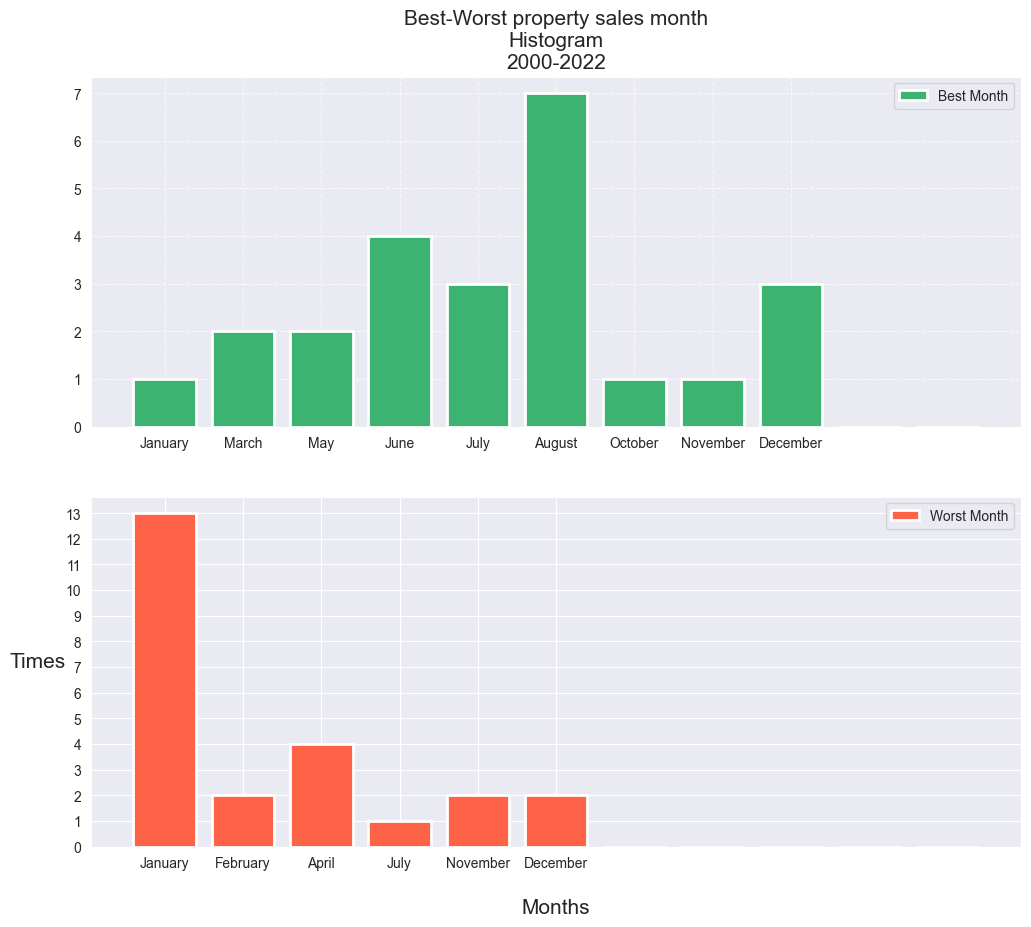

In [13]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12,10))
ax.grid(True, ls='dashed', alpha=0.7)
ax.grid(which='minor', alpha=0.3)
ax.set_title('Best-Worst property sales month\nHistogram\n2000-2022', fontdict={'fontsize': 15})

ax.hist(best_performing_month_per_year.month,bins=range(12), histtype='bar', align='left', stacked=True, color='#3cb371',lw=2, label='Best Month', rwidth=0.8)

ax.yaxis.set_major_locator(MultipleLocator(1))

ax.legend()

ax2.hist(worst_performing_month_per_year.month, bins=range(12), align='left', label='Worst Month', rwidth=0.8, lw=2, color='#ff6347')


ax2.yaxis.set_major_locator(MultipleLocator(1))

ax2.yaxis.set_label_text('Times')
ax2.yaxis.label.set_rotation(0)
ax2.yaxis.labelpad = 20
ax2.yaxis.label.set_fontsize(15)

ax2.xaxis.set_label_text('Months')
ax2.xaxis.labelpad = 20
ax2.xaxis.label.set_fontsize(15)

ax2.legend()


# Next Steps
Check if there is info for the properties sold:
* Price sold
* Location

# 4.0 Property prices

Data to extract:
* Yearly average property prices

Group By Year and find average price.


In [14]:
yearly_property_prices = sales_data_20_years['price'].groupby(
    sales_data_20_years['date_of_sale'].str[:4]
).mean()

<Axes: xlabel='date_of_sale'>

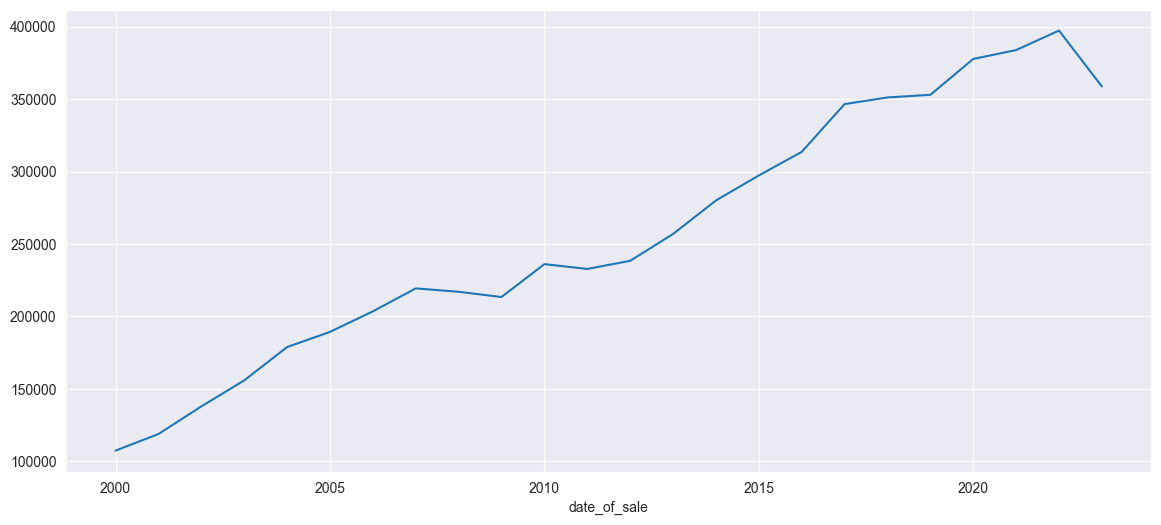

In [150]:
yearly_property_prices.plot(figsize=(14,6))

# 4.1 Property prices by area

First find the average sales price for each county, and then visualize the counties to see how their averages compare to each other.

In [62]:
average_price_by_county = sales_data_20_years['price'].groupby(sales_data_20_years['county']).mean().to_frame().reset_index()
average_price_by_county = average_price_by_county.sort_values('price')

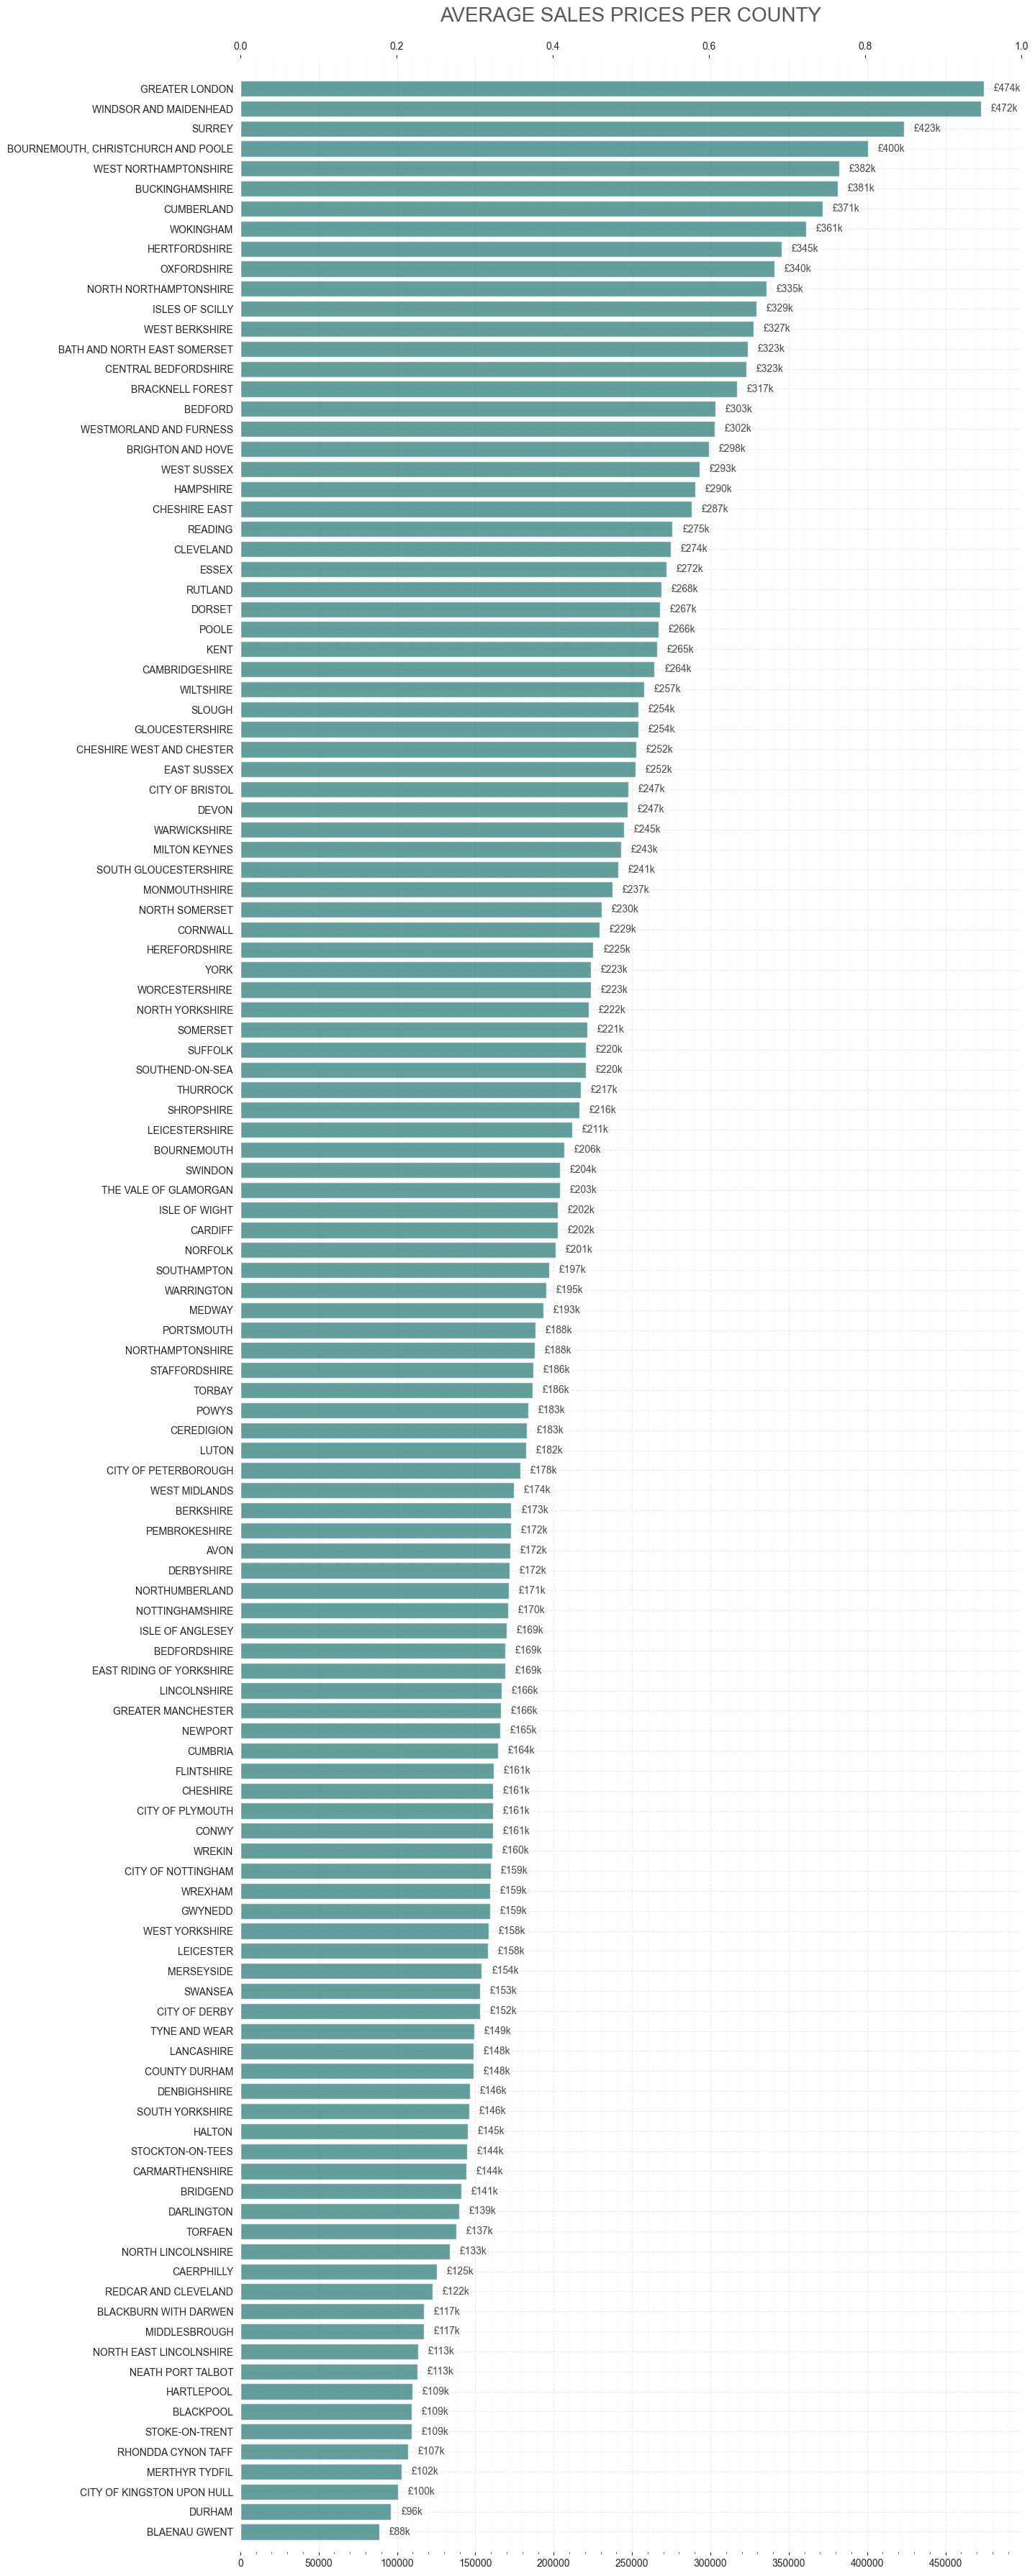

In [147]:
fig_avg, avg_ax = plt.subplots(figsize=(14, 45))

avg_ax.set_title('AVERAGE SALES PRICES PER COUNTY',color='#595959', fontdict={'fontsize': 20}, pad=20)
avg_ax.grid(True, ls='dashed', color='#e6e6e6', alpha=0.8)
avg_ax.grid(which='minor', color='#e6e6e6', alpha=0.1)
avg_ax.set_facecolor('#ffffff')

avg_ax2 = avg_ax.twiny()
avg_ax2.grid(False)

sales_per_county = avg_ax.barh(
    average_price_by_county.county,
    average_price_by_county.price,
    color='#217574',
    alpha=0.7,
    height=0.8,
)

# adding labels at the end of the bars to visualize the prices better
avg_ax.bar_label(
    sales_per_county,
    [f"£{int(price/1000)}k" for price in average_price_by_county['price']],
    padding=10,
    color='#4d4d4d'
)

avg_ax.xaxis.set_major_locator(MultipleLocator(50000))
avg_ax.xaxis.set_minor_locator(MultipleLocator(10000))

# Removing massive padding in the axis
plt.ylim(top=average_price_by_county['county'].count() + 0.5, bottom= -1)

plt.show()

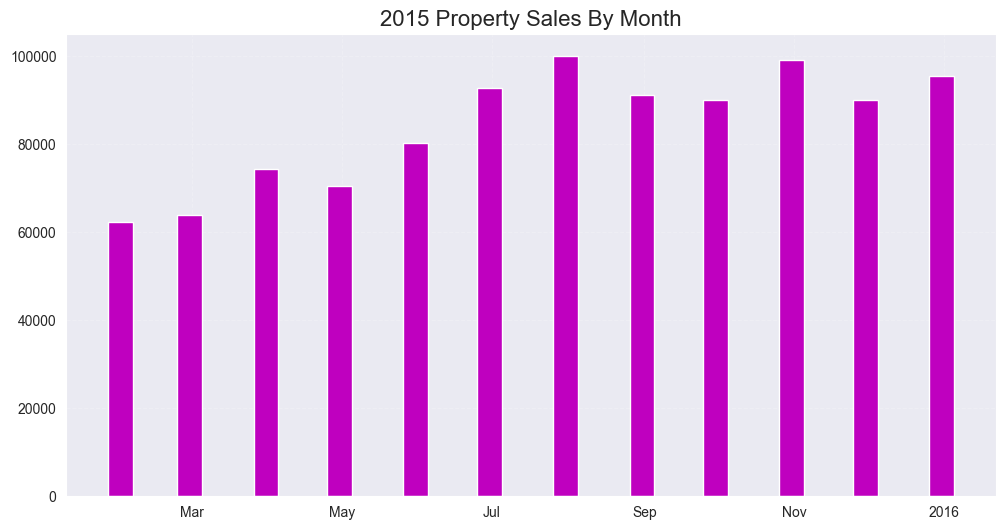

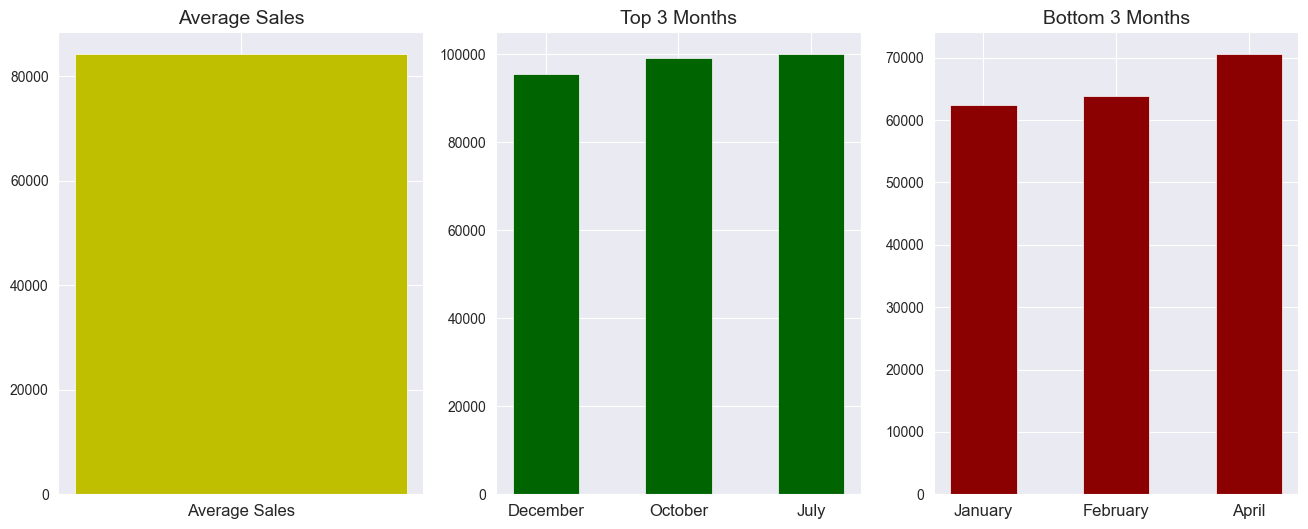

In [16]:
data_for_2015 = yearly_data_since_2015['sales_data_2015'].copy()
data_for_2015['date_of_sale'] = pd.to_datetime(data_for_2015['date_of_sale'])
data_for_2015 = data_for_2015.sort_values('date_of_sale')
monthly_sales_for_2015 = data_for_2015.groupby(pd.Grouper(key='date_of_sale', freq='M')).size().reset_index(name='count')


fig, ax = plt.subplots(figsize=(12, 6))
ax.grid(True, alpha=0.2, ls='dashed')

cdf = mpl.dates.ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(cdf)
ax.set_title('2015 Property Sales By Month', fontsize=16)

x = monthly_sales_for_2015['date_of_sale']
y = monthly_sales_for_2015['count']
ax.bar(x, y, color='m', width=10,)

# sorting by sales, giving average, top 3 months and bottom 3 months
monthly_sales_for_2015 = monthly_sales_for_2015.sort_values('count')
average = monthly_sales_for_2015['count'].mean()

# Getting the info for the bottom 3 months and creating a new column to store the month name
bottom_3 = monthly_sales_for_2015.head(3).copy()
bottom_3['month_name'] = bottom_3['date_of_sale'].dt.strftime('%B')

# Getting the info for top 3 months, then creating a new column that stores only the months name
top_3 = monthly_sales_for_2015.tail(3).copy()
top_3['month_name'] = top_3['date_of_sale'].dt.strftime('%B')

fig, ax = plt.subplots(1, 3,figsize=(16, 6))

# Displaying the average sales
ax[0].bar(['Average Sales',], [average], lw=0.5, color='y')
ax[0].set_title('Average Sales', fontsize=14)
ax[0].yaxis.set_major_locator(MultipleLocator(20000))

# Displaying the top 3 months
ax[1].bar(top_3['month_name'], top_3['count'], lw=0.5, width=0.5, align='center', color='darkgreen')
ax[1].set_title('Top 3 Months', fontsize=14)

# Displaying the bottom 3 months
ax[2].bar(bottom_3['month_name'], bottom_3['count'], lw=0.5, width=0.5, align='center', color='darkred')
ax[2].set_title('Bottom 3 Months', fontsize=14)

for axis in ax:
    
    for tick_label in axis.get_xticklabels():
        tick_label.set_fontsize(12)


In [17]:
interest_rates_data = pd.read_csv('datasets/Bank Rate history and data Bank of England Database.csv')

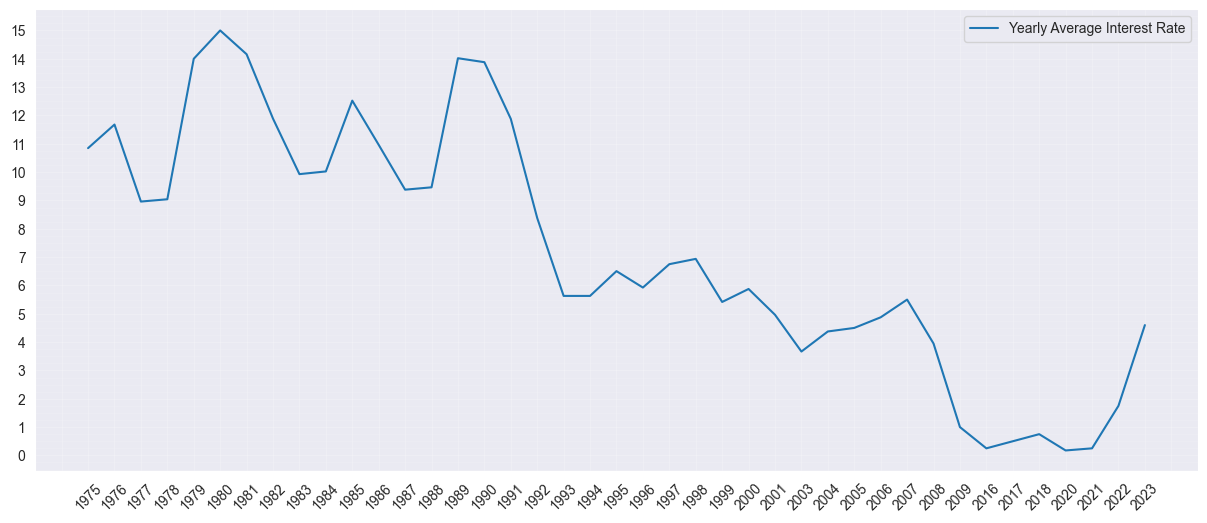

In [19]:
interest_rates_data['Date Changed'] = pd.to_datetime(interest_rates_data['Date Changed'], format='%d %m %Y')
yearly_average_interest_rates = interest_rates_data['Rate'].groupby(interest_rates_data['Date Changed'].dt.strftime('%Y')).mean().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(15, 6))
ax.grid(True, alpha=0.2)
ax.grid(True,which='minor', alpha=0.1)
ax.plot(yearly_average_interest_rates['Date Changed'], yearly_average_interest_rates['Rate'], label='Yearly Average Interest Rate')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(12))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.legend()

for tick_label in ax.get_xticklabels():
    tick_label.set_rotation(45)

